# Full Example

This notebook contains a full example of training and evaluating a KAN model for a task. The task at hand is learning a multivariate function, namely

$$ f\left(x_1,x_2\right) = \exp\left(\sin\left(\pi x_1\right) + x_2\right) $$

To do so, we will first generate some training samples, i.e. create an artificial dataset.

## Dataset Creation

We randomly sample $N$ points from this function in the $\left[-2,2\right] \times \left[-2,2\right]$ range. Some of them are retained for training, while the rest are used for evaluation.

In [1]:
import jax
import jax.numpy as jnp

# Define the true function
def true_f(x_1,x_2):
    return jnp.exp(jnp.sin(jnp.pi*x_1)+x_2)

N = 5000

# Randomly selected x_1, x_2 in [-2,2]
x_1 = 4*jax.random.uniform(jax.random.PRNGKey(42), (N,)) - 2
x_2 = 4*jax.random.uniform(jax.random.PRNGKey(43), (N,)) - 2

# Get back ys
y = true_f(x_1,x_2)

We then use sklearn's built-in methods to split the "dataset" for training and testing. Of course this can be handled manually, but we're lazy. To run the following cell, we used `scikit-learn==1.4.2`.

In [2]:
from sklearn.model_selection import train_test_split

# Combine x_1 and x_2 into a single array
X = jnp.stack((x_1, x_2), axis=-1)

# Split the dataset into training and evaluation sets
X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=0.2, random_state=42)

## Data Loader

We then define our data loaders to yield batches of data during training and evaluation.

In [3]:
def data_loader(X, y, batch_size, seed):
    dataset_size = len(X)
    indices = jax.random.permutation(jax.random.PRNGKey(seed), dataset_size)
    
    for start_idx in range(0, dataset_size, batch_size):
        batch_indices = indices[start_idx:start_idx + batch_size]
        yield X[batch_indices], y[batch_indices]

In [4]:
batch_size = 500

## Initialization

With the data at hand, we proceed with the initialization of the necessary items. For the optimization part we will be using `optax`.

In [5]:
import optax
from flax import linen as nn

import sys
import os

path_to_src = os.path.abspath(os.path.join(os.getcwd(), '../src'))
if path_to_src not in sys.path:
    sys.path.append(path_to_src)

from KAN import KAN

In [11]:
# Initialize model
key = jax.random.PRNGKey(0)

layer_dims = [2, 5, 1]
model = KAN(layer_dims=layer_dims, k=3, add_bias=True)
variables = model.init(key, jnp.ones([1, 2]))

In [12]:
# Initialize optimizer
learning_rate = 0.01
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(variables['params'])

## Loss Function

This is the point where we need to define our loss function. For the predictions we simply use RMSE Loss, while for the regularization we follow the arXiv preprint's direction and use the layer norms and entropy.

In [8]:
def loss_fn(variables, x, y):
    # Forward pass to acquire predictions and spl_regs
    preds, spl_regs = model.apply(variables, x)

    # Define the prediction loss
    loss_pred = jnp.sqrt(jnp.mean((preds-y)**2))

    # Calculate the regularization loss
    loss_reg = 0.0
    for spl_reg in spl_regs:
        # L1 regularization loss
        phis = spl_reg.reshape(-1)
        L1 = jnp.sum(phis)
        # Entropy regularization loss
        frac = phis/L1
        Entropy = -jnp.sum(frac * jnp.log2(frac + 1e-4))
        # Return full regularization loss
        mu_1, mu_2 = 1.0, 1.0
        loss_reg += (mu_1 * L1) + (mu_2 * Entropy)

    # Return total loss
    ell = 1.0
    total_loss = loss_pred + (ell * loss_reg)
    
    return total_loss

In [8]:
def loss_fn(variables, x, y):
    # Forward pass to acquire predictions and spl_regs
    preds, _ = model.apply(variables, x)

    # Define the prediction loss
    total_loss = jnp.mean((preds-y)**2)
    
    return total_loss

## Training

All the pieces of the puzzle are ready, so we may define a `train_step` and start training.

In [9]:
@jax.jit
def train_step(variables, opt_state, x, y):
    
    loss, grads = jax.value_and_grad(loss_fn)(variables, x, y)
    
    updates, opt_state = optimizer.update(grads['params'], opt_state, variables['params'])
    params = optax.apply_updates(variables['params'], updates)
    
    new_variables = {'params': params, 'state': variables['state']}
    
    return new_variables, opt_state, loss

Of course, we must also define a `grid_values` list and perform updates periodically between epochs. The first value is always 3, because this corresponds to the first initialization and occurs at the first epoch.

In [13]:
# Training epochs
num_epochs = 201
# Grid sizes for updates and epochs to occur in. Format = epoch : value
grid_upds = {0 : 3, 20: 10, 40: 20, 90: 50, 140: 100}

losses = []
for epoch in range(num_epochs):
    # Check if we're in an update epoch
    if epoch in grid_upds.keys():
        print(f"Epoch {epoch+1}: Performing grid update")
        # Get grid size
        G_new = grid_upds[epoch]
        # Perform the update
        updated_variables = model.apply(variables, X_train, G_new, method=model.update_grids)
        variables = updated_variables.copy()
        # Re-initialize optimizer when using optax - Adam
        opt_state = optimizer.init(variables['params'])
    
    # Batch training
    epoch_loss = 0.0
    for x_batch, y_batch in data_loader(X_train, y_train, batch_size, 42):
        # Calculate the loss
        variables, opt_state, loss = train_step(variables, opt_state, x_batch, y_batch)
        epoch_loss += loss
    
    losses.append(epoch_loss)
    if epoch % 10 == 0:
        print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")

Epoch 1: Performing grid update
Epoch 1, Loss: 117.2675
Epoch 11, Loss: 107.8856
Epoch 21: Performing grid update
Epoch 21, Loss: 99.0604
Epoch 31, Loss: 91.6570
Epoch 41: Performing grid update
Epoch 41, Loss: 86.6623
Epoch 51, Loss: 83.3055
Epoch 61, Loss: 81.9056
Epoch 71, Loss: 81.4573
Epoch 81, Loss: 81.3411
Epoch 91: Performing grid update
Epoch 91, Loss: 81.3171
Epoch 101, Loss: 81.3018
Epoch 111, Loss: 81.2990
Epoch 121, Loss: 81.2960
Epoch 131, Loss: 81.2926
Epoch 141: Performing grid update
Epoch 141, Loss: 81.2940
Epoch 151, Loss: 81.2810
Epoch 161, Loss: 81.2738
Epoch 171, Loss: 81.2677
Epoch 181, Loss: 81.2632
Epoch 191, Loss: 81.2591
Epoch 201, Loss: 81.2556


## Evaluation

With the trained model available (i.e. the `variables` dict) we may proceed with evaluation.

In [14]:
@jax.jit
def eval_step(variables, x, y):
    predictions, _ = model.apply(variables, x)
    mse_loss = jnp.mean((predictions - y) ** 2)
    return mse_loss, predictions

In [15]:
# Evaluation loop
eval_loss = 0
all_predictions = []

for x_batch, y_batch in data_loader(X_eval, y_eval, batch_size, 42):
    loss, predictions = eval_step(variables, x_batch, y_batch)
    eval_loss += loss
    all_predictions.append(predictions)

eval_preds = jnp.concatenate(all_predictions)

print(f"Evaluation Loss: {eval_loss:.4f}")

Evaluation Loss: 19.8850


Let's plot the results and compare them with the ground truth.

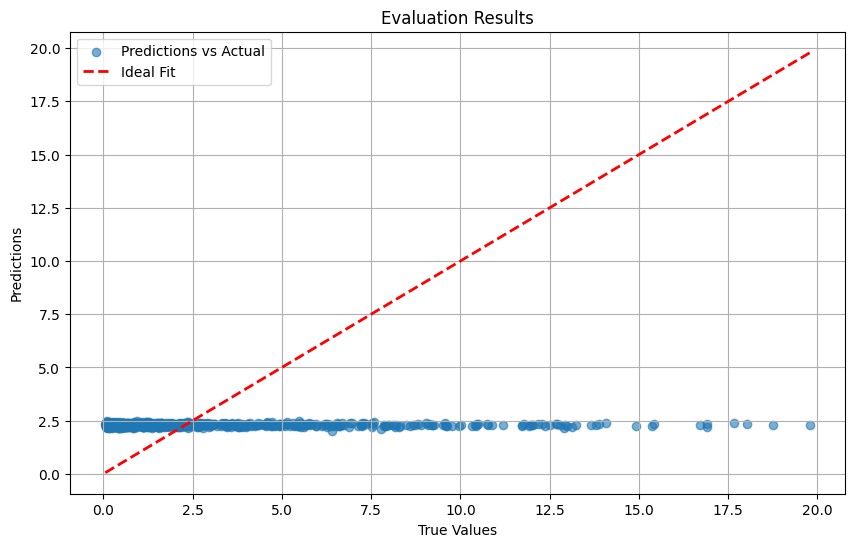

In [16]:
import matplotlib.pyplot as plt

# Plot the evaluation results
plt.figure(figsize=(10, 6))

plt.scatter(y_eval, eval_preds, label='Predictions vs Actual', alpha=0.6)

plt.plot([y_eval.min(), y_eval.max()], [y_eval.min(), y_eval.max()], 'r--', lw=2, label='Ideal Fit')

plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Evaluation Results')

plt.legend()
plt.grid(True)

plt.show()

In [ ]:
# $$ f\left(x_1,x_2,x_3\right) = \left(x_1^2 + x_2^2\right)^3\cdot\exp\left(x_1 \cdot x_3\right) $$